In [ ]:
import tensorflow as tf
import os
import random
# import the libraries as shown below
import numpy.random
from skimage.transform import resize
import numpy as np
import pandas as pds

import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten
from tensorflow.keras.models import Model
# from tensorflow.keras.applications.vgg19 import preprocess_input
# from keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.vgg16 import preprocess_input
# from keras.applications.vgg16 import VGG16
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img

from tensorflow.keras.models import Sequential
from keras.utils import plot_model

from tensorflow.keras.layers import GlobalAveragePooling2D, GlobalMaxPooling2D, Reshape, Dense, Input, Concatenate, Conv2D, Multiply

In [ ]:
from google.colab import drive

drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
from google.colab import drive
import os

# Mount Google Drive
drive.mount('/content/gdrive')

# Path to the folder in Google Drive
train_path = '/content/gdrive/MyDrive/RESEARCH/Dataset/Knee_Xray/train'
num_of_classes =5

# Check if the folder exists
if os.path.exists(train_path):
    # List all files and folders in the specified folder
    file_list = os.listdir(train_path)

    for file_name in file_list:
        file_path = os.path.join(train_path, file_name)
        if os.path.isdir(file_path):
            print(f"Folder: {file_name}")
        else:
            print(f"File: {file_name}")
else:
    print("Folder not found.")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
Folder: 4
Folder: 3
Folder: 1
Folder: 0
Folder: 2


In [ ]:
from google.colab import drive
import os

# Mount Google Drive
drive.mount('/content/gdrive')

# Path to the folder in Google Drive
test_path = '/content/gdrive/MyDrive/RESEARCH/Dataset/Knee_Xray/test'

# Check if the folder exists
if os.path.exists(test_path):
    # List all files and folders in the specified folder
    file_list = os.listdir(test_path)

    for file_name in file_list:
        file_path = os.path.join(test_path, file_name)
        if os.path.isdir(file_path):
            print(f"Folder: {file_name}")
        else:
            print(f"File: {file_name}")
else:
    print("Folder not found.")


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
Folder: 4
Folder: 2
Folder: 1
Folder: 0
Folder: 3


In [ ]:
import tensorflow as tf
import numpy as np
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report, confusion_matrix
# Define the path to the dataset
#dataset_path = test_path_new

# Define the batch size and image size
batch_size = 32
img_height = 256
img_width = 256

# Define the data augmentation pipeline
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal"),
    tf.keras.layers.experimental.preprocessing.RandomCrop(224, 224),
    # tf.keras.layers.experimental.preprocessing.RandomRotation(0.5),
    # tf.keras.layers.experimental.preprocessing.RandomZoom(0.1)
])

Testing_data_augmentation = tf.keras.Sequential([
        tf.keras.layers.experimental.preprocessing.Resizing(224, 224),
    ])

# Create a dataset from the directory of images
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_path, #dataset_path,
    #validation_split=0.3,
    #subset="training",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)



# Split the dataset into training and testing sets
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
     test_path, #dataset_path,
    #validation_split=0.3,
    #subset="validation",
    seed=123,
    #image_size=(img_height, img_width),
    batch_size=batch_size)

# Define the number of classes
num_classes = len(train_ds.class_names)
print(train_ds.class_names)
# Configure the datasets for performance
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
#val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)


Found 5778 files belonging to 5 classes.
Found 1656 files belonging to 5 classes.
['0', '1', '2', '3', '4']


In [ ]:
# Apply the data augmentation pipeline to the dataset
train_ds = train_ds.map(lambda x, y: (data_augmentation(x), y))
test_ds = test_ds.map(lambda x, y: (Testing_data_augmentation(x), y))

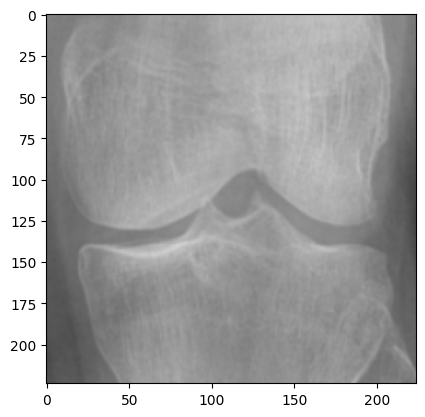

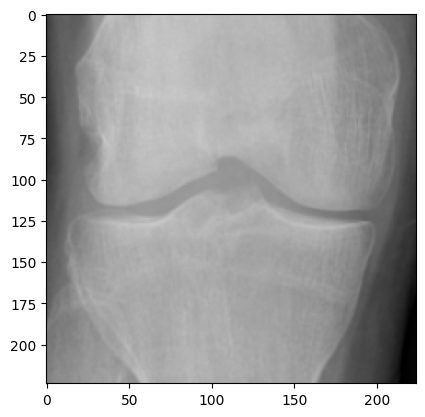

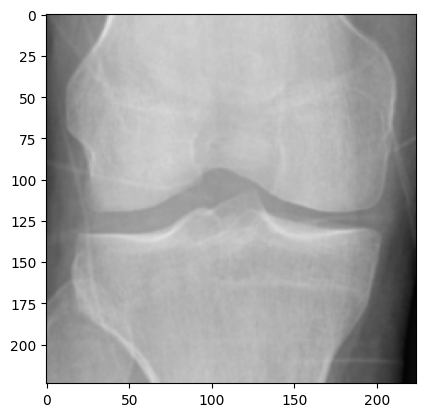

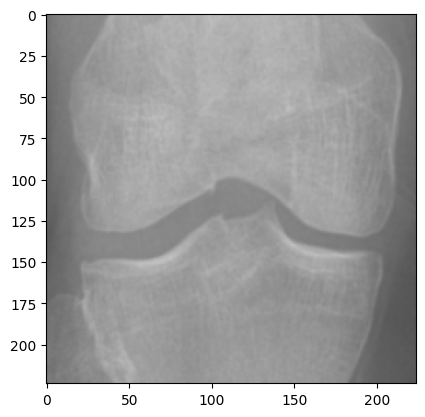

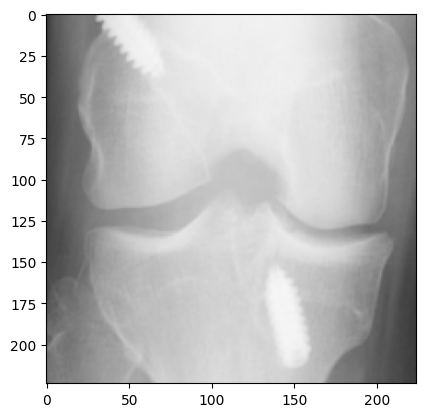

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt

for images, labels in test_ds.take(1):
    for i in range(5):
        image = images[i].numpy().astype(np.uint8)
        image = Image.fromarray(image)
        plt.imshow(image)
        plt.show()


In [ ]:

from tensorflow.keras.layers import Activation


def channel_attention_module(x, ratio=8):
    batch, _, _, channel = x.shape

    # Shared layers
    l1 = Dense(channel // ratio, activation="relu", use_bias=False)
    l2 = Dense(channel, use_bias=False)

    # Global Average Pooling
    x1 = GlobalAveragePooling2D()(x)
    x1 = l1(x1)
    x1 = l2(x1)

    # Global Max Pooling
    x2 = GlobalMaxPooling2D()(x)
    x2 = l1(x2)
    x2 = l2(x2)

    # Add both the features and pass through sigmoid
    feats = x1 + x2
    feats = Activation("sigmoid")(feats)
    feats = Multiply()([x, feats])

    return feats

def spatial_attention_module(x):
    # Average Pooling
    x1 = tf.reduce_mean(x, axis=-1)
    x1 = tf.expand_dims(x1, axis=-1)

    # Max Pooling
    x2 = tf.reduce_max(x, axis=-1)
    x2 = tf.expand_dims(x2, axis=-1)

    # Concatenate both the features
    feats = Concatenate()([x1, x2])

    # Conv layer
    feats = Conv2D(1, kernel_size=7, padding="same", activation="sigmoid")(feats)
    feats = Multiply()([x, feats])

    return feats

def cbam(x):
    x = channel_attention_module(x)
    x = spatial_attention_module(x)
    return x

def efficientnet_cbam(input_shape=(128, 128, 3), classes=1000):
    # Load EfficientNetB0 model
    net1 = keras.applications.EfficientNetB0(include_top = False , input_shape = (224,224,3),weights='imagenet')

    # Apply CBAM attention to the output of the base model
    x = cbam(net1.output)

    # Add a global average pooling layer and a dense output layer
    x = GlobalAveragePooling2D()(x)
    x = Dense(classes, activation='softmax')(x)

    # Create the final model
    model = Model(inputs=net1.input, outputs=x)

    return model

if __name__ == "__main__":
    input_shape = (224, 224, 3)
    classes = 5
    model = efficientnet_cbam(input_shape, classes)
    model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 rescaling_4 (Rescaling)     (None, 224, 224, 3)          0         ['input_3[0][0]']             
                                                                                                  
 normalization_2 (Normaliza  (None, 224, 224, 3)          7         ['rescaling_4[0][0]']         
 tion)                                                                                            
                                                                                                  
 rescaling_5 (Rescaling)     (None, 224, 224, 3)          0         ['normalization_2[0][0]'] 

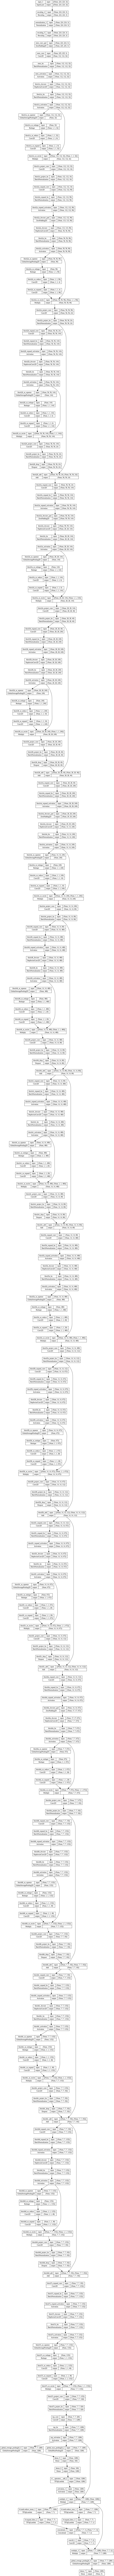

In [ ]:


tf.keras.utils.plot_model(model, show_shapes=True, to_file='CNN_block.png')

In [ ]:
# Compile the  model

learning_rate = 0.003
num_epochs = 50


#decay_rate = learning_rate / 10;
model.compile(optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=learning_rate),
                     loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
                     metrics=['accuracy'])

# Print the summary of the fusion model
# fusion_model.summary()(

'''
ES = tf.keras.callbacks.EarlyStopping(
    patience=10,
    min_delta=0.01,
    verbose=1
)
'''
# Cache and prefetch the test dataset for better performance
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

# Train the model for the specified number of epochs
history = model.fit(train_ds, epochs=num_epochs, validation_data=test_ds, verbose=1,shuffle=True)

# Evaluate the model on the test dataset
test_loss, test_acc = model.evaluate(test_ds, verbose=1)
print('Test accuracy:', test_acc)


Epoch 1/50
181/181 [==============================] - 984s 1s/step - loss: 1.2067 - accuracy: 0.4775 - val_loss: 2.9871 - val_accuracy: 0.3871
Epoch 2/50
181/181 [==============================] - 52s 285ms/step - loss: 1.0013 - accuracy: 0.5777 - val_loss: 1.7517 - val_accuracy: 0.4529
Epoch 3/50
181/181 [==============================] - 52s 285ms/step - loss: 0.9536 - accuracy: 0.5993 - val_loss: 1.2823 - val_accuracy: 0.5483
Epoch 4/50
181/181 [==============================] - 52s 288ms/step - loss: 0.9129 - accuracy: 0.6208 - val_loss: 1.3840 - val_accuracy: 0.5761
Epoch 5/50
181/181 [==============================] - 52s 288ms/step - loss: 0.8638 - accuracy: 0.6385 - val_loss: 0.9109 - val_accuracy: 0.6280
Epoch 6/50
181/181 [==============================] - 52s 285ms/step - loss: 0.8578 - accuracy: 0.6378 - val_loss: 0.9173 - val_accuracy: 0.5960
Epoch 7/50
181/181 [==============================] - 54s 298ms/step - loss: 0.8231 - accuracy: 0.6521 - val_loss: 1.0091 - val_accu

In [ ]:
# Compile the fusion model

learning_rate = 0.0003
num_epochs = 20


#decay_rate = learning_rate / 10;
model.compile(optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=learning_rate),
                     loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
                     metrics=['accuracy'])

# Print the summary of the fusion model
# fusion_model.summary()

'''
ES = tf.keras.callbacks.EarlyStopping(
    patience=10,
    min_delta=0.01,
    verbose=1
)
'''
# Cache and prefetch the test dataset for better performance
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

# Train the model for the specified number of epochs
history = model.fit(train_ds, epochs=num_epochs, validation_data=test_ds, verbose=1,shuffle=True)

# Evaluate the model on the test dataset
test_loss, test_acc = model.evaluate(test_ds, verbose=1)
print('Test accuracy:', test_acc)

Epoch 1/20
181/181 [==============================] - 67s 308ms/step - loss: 0.3708 - accuracy: 0.8484 - val_loss: 0.9126 - val_accuracy: 0.6576
Epoch 2/20
181/181 [==============================] - 52s 286ms/step - loss: 0.3219 - accuracy: 0.8693 - val_loss: 0.9581 - val_accuracy: 0.6612
Epoch 3/20
181/181 [==============================] - 52s 285ms/step - loss: 0.2972 - accuracy: 0.8823 - val_loss: 0.9886 - val_accuracy: 0.6691
Epoch 4/20
181/181 [==============================] - 54s 297ms/step - loss: 0.2912 - accuracy: 0.8856 - val_loss: 1.0057 - val_accuracy: 0.6540
Epoch 5/20
181/181 [==============================] - 52s 285ms/step - loss: 0.2739 - accuracy: 0.8898 - val_loss: 1.0552 - val_accuracy: 0.6552
Epoch 6/20
181/181 [==============================] - 54s 298ms/step - loss: 0.2660 - accuracy: 0.8922 - val_loss: 1.0736 - val_accuracy: 0.6473
Epoch 7/20
181/181 [==============================] - 52s 285ms/step - loss: 0.2630 - accuracy: 0.8970 - val_loss: 1.0743 - val_ac

In [ ]:


# Predict the test labels
test_labels = []
predicted_labels = []
for images, labels in test_ds:
    predicted_labels_batch = model.predict(images)
    predicted_labels_batch = tf.argmax(predicted_labels_batch, axis=1)
    test_labels.append(labels.numpy())
    predicted_labels.append(predicted_labels_batch.numpy())

test_labels = np.concatenate(test_labels)
predicted_labels = np.concatenate(predicted_labels)




1/1 [==============================] - 2s 2s/step


Confusion matrix:


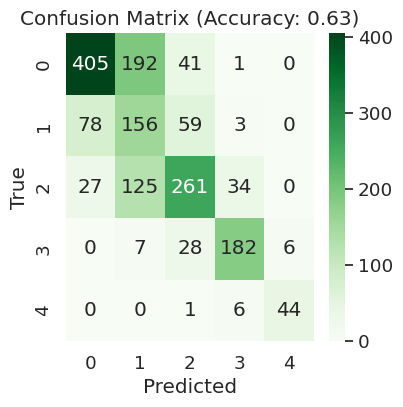

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
# Compute confusion matrix

confusion_mat = confusion_matrix(test_labels, predicted_labels)
print('Confusion matrix:')

class_labels =['0', '1','2','3','4']
plt.figure(figsize=(4,4))
sns.set(font_scale=1.2)

sns.heatmap(confusion_mat, annot=True, fmt="d", cmap="Greens", xticklabels=class_labels, yticklabels=class_labels)
# Calculate accuracy (optional)
accuracy = accuracy_score(test_labels, predicted_labels)
# Add labels and title
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title(f'Confusion Matrix (Accuracy: {accuracy:.2f})')

# Show the plot
plt.show()

In [ ]:

from sklearn.metrics import classification_report, confusion_matrix
print('Classification Report')
target_names = ['0', '1','2','3','4']
print(classification_report(test_labels, predicted_labels, target_names=target_names))


Classification Report
              precision    recall  f1-score   support

           0       0.79      0.63      0.70       639
           1       0.33      0.53      0.40       296
           2       0.67      0.58      0.62       447
           3       0.81      0.82      0.81       223
           4       0.88      0.86      0.87        51

    accuracy                           0.63      1656
   macro avg       0.69      0.68      0.68      1656
weighted avg       0.68      0.63      0.65      1656

